In [1]:
print('STOCK PREDICTION USING RNN LSTM')
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline

STOCK PREDICTION USING RNN LSTM


Using TensorFlow backend.


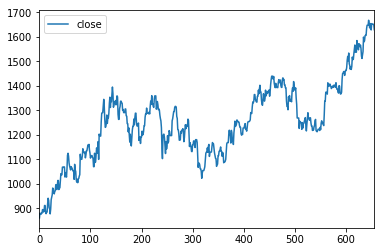

<Figure size 432x288 with 0 Axes>

In [4]:
data_csv = pd.read_csv('final_dataset1.csv')

data_csv[['close']].plot()
plt.show()
plt.clf()

In [5]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data_csv)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data_csv)
print("total_data:", total_data)

('total_data:', 657)


In [6]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

#close, compund, neg, neu, pos, open, high, low, volume
# Order -> 8,1,2,3,4,5,6,7,9
yt = data_csv.iloc[start:total_data,4] #close
yt1 = data_csv.iloc[start:total_data,9] #compund
yt2 = data_csv.iloc[start:total_data,6] #neg
yt3 = data_csv.iloc[start:total_data,7] #neu
yt4 = data_csv.iloc[start:total_data,8] #pos
yt5 = data_csv.iloc[start:total_data,1] #open
yt6 = data_csv.iloc[start:total_data,2] #high
yt7 = data_csv.iloc[start:total_data,3] #low
vt = data_csv.iloc[start:total_data,5] #volume

print("yt head (close) :")
print(yt.head())

yt head (close) :
1    879.80
2    876.95
3    874.85
4    879.55
5    879.55
Name: close, dtype: float64


In [7]:
#shift next day close and next day compund 
yt_ = yt.shift(-1) #shifted close

#taking only: close, next_close, compund, volume, open, high, low
data = pd.concat([yt, yt_, yt1, vt, yt5, yt6, yt7], axis=1)
data.columns = ['yt', 'yt_', 'yt1','vt', 'yt5', 'yt6', 'yt7']

data = data.dropna()
     
print(data[:10])

        yt     yt_     yt1       vt     yt5     yt6    yt7
1   879.80  876.95 -0.2960  2862754  873.00  881.95  865.0
2   876.95  874.85  0.0000  1625072  877.05  882.15  870.0
3   874.85  879.55  0.9924  1475886  877.10  886.90  870.3
4   879.55  879.55  0.6369  4983550  872.00  882.50  862.1
5   879.55  894.10  0.3182  4983550  872.00  882.50  862.1
6   894.10  894.10  0.3182  5096356  885.00  897.00  883.5
7   894.10  884.35  0.6597  5096356  885.00  897.00  883.5
8   884.35  887.40  0.6597  2581562  887.30  892.95  880.0
9   887.40  910.95  0.5859  1794252  881.15  893.40  877.0
10  910.95  910.95 -0.4215  3080739  897.90  914.75  897.0


In [8]:
# target variable - closed price
# after shifting
y = data['yt_'] #next_close

# close, compund, next_compund, volume, open, high, low   
cols = ['yt', 'yt1', 'vt', 'yt5', 'yt6', 'yt7']
x = data[cols]

In [9]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

In [10]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [15]:
batch_size = 32
nb_epoch = 200
neurons = 35
dropout = 0.1

seed = 2016
np.random.seed(seed)

model = Sequential ()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))

print(model.summary())

model.compile(loss='mean_squared_error' , optimizer='RMSprop')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(35, return_sequences=True, activation="tanh", input_shape=(6, 1), recurrent_activation="hard_sigmoid")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activity_regularizer=<keras.reg..., activation="linear")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 6, 35)             5180      
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 35)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 6, 35)             9940      
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 35)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 35)                9940      
_________________________________________________________________
dropout_9 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 36        
__________

419/419 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0055
Epoch 74/200
419/419 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0050
Epoch 75/200
419/419 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0043
Epoch 76/200
419/419 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0099
Epoch 77/200
419/419 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0063
Epoch 78/200
419/419 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0067
Epoch 79/200
419/419 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0054
Epoch 80/200
419/419 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0056
Epoch 81/200
419/419 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0072
Epoch 82/200
419/419 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0077
Epoch 83/200
419/419 [==============================] - 0s - loss: 0.0051 - val_los

419/419 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0033
Epoch 161/200
419/419 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0038
Epoch 162/200
419/419 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0038
Epoch 163/200
419/419 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0044
Epoch 164/200
419/419 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0033
Epoch 165/200
419/419 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0037
Epoch 166/200
419/419 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0045
Epoch 167/200
419/419 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0039
Epoch 168/200
419/419 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0036
Epoch 169/200
419/419 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0043
Epoch 170/200
419/419 [==============================] - 0s - loss: 0.0049

In [16]:
import math
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
rmse_train = math. sqrt(score_train)
rmse_test = math.sqrt(score_test)
print("in train MSE = ", round( score_train ,4)) 
print("in test MSE = ", score_test )
print("RMSE in train = ", rmse_train)
print("RMSE in test = ", rmse_test)

121/130 [==========================>...] - ETA: 0s('in train MSE = ', 0.0049)
('in test MSE = ', 0.013172839341086729)
('RMSE in train = ', 0.07029817265993867)
('RMSE in test = ', 0.1147729904685189)


In [17]:
model_json = model.to_json()
with open("model_rms100e_new.json", "w") as json_file:
    json_file.write(model_json)
 #serialize weights to HDF5
model.save_weights("model_rms100e_new.h5")
print("Saved model to disk")

Saved model to disk


Inputs: (None, 6, 1)
Outputs: (None, 1)
Actual input: (130, 6, 1)
Actual output: (130, 1)
prediction data:
[ 1554.60888672]
actual data
[[  1.28985000e+03   2.96000000e-01   2.70420800e+06   1.27050000e+03
    1.29500000e+03   1.27050000e+03]
 [  1.26825000e+03   4.01900000e-01   2.33339800e+06   1.28700000e+03
    1.28970000e+03   1.26000000e+03]
 [  1.26655000e+03   6.24900000e-01   1.62888500e+06   1.27900000e+03
    1.27900000e+03   1.25700000e+03]
 [  1.25920000e+03  -4.01900000e-01   1.73169100e+06   1.26200000e+03
    1.27740000e+03   1.25525000e+03]
 [  1.26915000e+03   3.18200000e-01   2.77532200e+06   1.26200000e+03
    1.27800000e+03   1.26200000e+03]
 [  1.26915000e+03   7.09600000e-01   2.77532200e+06   1.26200000e+03
    1.27800000e+03   1.26200000e+03]
 [  1.24790000e+03   4.76700000e-01   1.27950800e+06   1.26300000e+03
    1.26390000e+03   1.24265000e+03]
 [  1.23555000e+03   8.72000000e-01   1.93565200e+06   1.24590000e+03
    1.25590000e+03   1.22780000e+03]
 [  1.23

/home/sugar/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


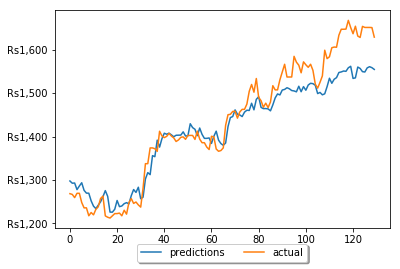

<function matplotlib.pyplot.clf>

In [18]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)

#########################################################################
'''Plotting'''
plt.plot(pred, label="predictions")

y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len( y_test), 1)))
plt.plot([row[0] for row in y_test], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)


fmt = 'Rs{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.show()
plt.clf

#1632.2